### Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, Swinv2ForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import wandb


In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

### Hyperparameters

In [5]:
batch_size = 16
learning_rate = 1e-4
num_epochs = 60
save_interval = 5
num_classes = 4

OUTPUT_DIR = "aug-swinv2-base"

sweep_config = {
    'method': 'grid', 
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'batch_size': {'values': [16, 32]},
        'learning_rate': {'values': [1e-5, 1e-4, 5e-4]}, 
        'num_epochs': {'value': num_epochs},  
        'num_classes': {'value': num_classes}, 
    }
}

In [15]:
sweep_id = wandb.sweep(sweep_config, project="aug-swinv2-bc-hp-base-patch4-window8-v2")

Create sweep with ID: x5aruupt
Sweep URL: https://wandb.ai/adam-kacmar59-fiit-stu/aug-swinv2-bc-hp-base-patch4-window8-v2/sweeps/x5aruupt


### Data Preprocessing

In [9]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window8-256")

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
]) # This transform has been used for training the models on PlantVillage dataset. Currently avoided.

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

### Load Datasets


In [6]:
dataset = load_dataset("adamkatchee/grape-leaf-disease-augmented-dataset")

In [8]:
train_raw = dataset["train"]
test_raw  = dataset["test"]

HuggingFace Dataset to PyTorch Dataset Wrapper

In [7]:
class DatasetWrapper(Dataset):
    def __init__(self, split, transform=None):
        self.data = split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_or_path = item["image"]

        if isinstance(img_or_path, Image.Image):
            image = img_or_path.convert("RGB")
        else:
            image = Image.open(img_or_path).convert("RGB")

        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
full_train_dataset = DatasetWrapper(train_raw)

train_size = int(0.875 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

train_indices = train_subset.indices
val_indices = val_subset.indices

train_dataset_full = DatasetWrapper(train_raw, transform=transform)
val_dataset_full = DatasetWrapper(train_raw, transform=transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

test_dataset = DatasetWrapper(test_raw, transform=transform)

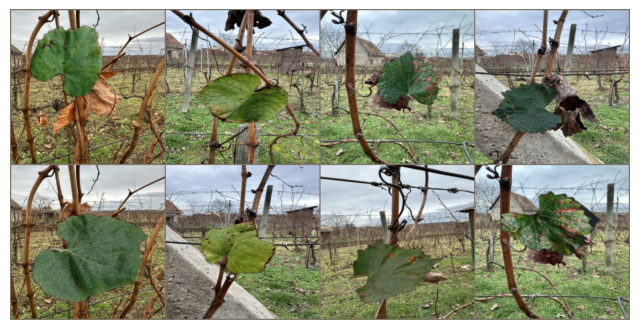

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

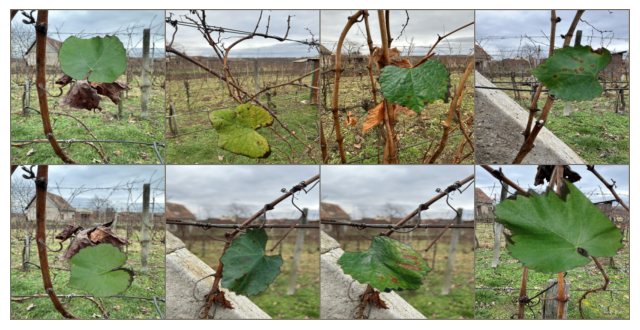

In [12]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Training Function


In [20]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

### Validation Function


In [21]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy

### Main Function


In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

def train_with_sweep():
    wandb.init()

    config = wandb.config

    model = Swinv2ForImageClassification.from_pretrained(
        "microsoft/swinv2-base-patch4-window8-256", 
        num_labels=config.num_classes, 
        ignore_mismatched_sizes=True)
    model.to(device)    

    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate
        )
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    patience = 10 
    min_delta = 1e-4 
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(config.num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")

        val_loss, val_accuracy = validate(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'epoch': epoch + 1
        })

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0

            torch.save(model.state_dict(), f'aug-hp-swinv2-base/model_lr{config.learning_rate}_bs{config.batch_size}.pth')
            print(f"New best model saved. Validation Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("Evaluating the best model on the test dataset...")
    model.load_state_dict(torch.load(f'aug-hp-swinv2-base/model_lr{config.learning_rate}_bs{config.batch_size}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    wandb.log({'final_test_accuracy': test_accuracy})

wandb.agent(sweep_id, function=train_with_sweep)